<a href="https://colab.research.google.com/github/Fatikah002/MachineLearning/blob/main/14_Fatikah_Salsabilla_UTS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install annoy

In [ ]:
# 1. Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# 2.  Upload atau load dataset dari Kaggle
# (ubah path sesuai dataset masing-masing)
import kagglehub
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

df = pd.read_csv(f"{path}/UCI_Credit_Card.csv")
df.info()
df.describe()
df.head()

Using Colab cache for faster access to the 'default-of-credit-card-clients-dataset' dataset.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Tuliskan catatan singkat tentang kondisi awal dataset dan kolom mana yang memiliki missing values
*   Dataset Default of Credit Card Client memiliki 30.000 baris dan 25 kolom.Semua kolom terisi, tidak ada nilai yang hilang.

In [ ]:
# 3.Data Preprocessing

# Cek missing value
print("Jumlah missing value per kolom:")
print(df.isnull().sum())

# Tambah fitur baru
bill_cols = [c for c in df.columns if c.startswith('BILL_AMT')]
pay_cols = [c for c in df.columns if c.startswith('PAY_AMT')]

if 'LIMIT_BAL' in df.columns:
    df['AVG_BILL_AMT'] = df[bill_cols].mean(axis=1)
    df['AVG_PAY_AMT'] = df[pay_cols].mean(axis=1)

    df['PAYMENT_RATIO'] = df['AVG_PAY_AMT'] / (df['AVG_BILL_AMT']+ 1e-6)

print("\nFitur baru berhasil ditambahkan:")
print([col for col in df.columns if 'AMT' in col or 'RATIO' in col])

# drop kolom ID dan label
drop_cols = ['ID', 'default.payment.next.month']
df_clean = df.drop(columns=drop_cols)


# Normalisasi data numerik
num_df = df_clean.select_dtypes(include=['float64','int64'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

df.head()

Jumlah missing value per kolom:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

Fitur baru berhasil ditambahkan:
['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_A

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,AVG_BILL_AMT,AVG_PAY_AMT,PAYMENT_RATIO
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,689.0,0.0,0.0,0.0,0.0,1,1284.000000,114.833333,0.089434
1,2,120000.0,2,2,2,26,-1,2,0,0,...,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,2846.166667,833.333333,0.292791
2,3,90000.0,2,2,2,34,0,0,0,0,...,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,16942.166667,1836.333333,0.108388
3,4,50000.0,2,2,1,37,0,0,0,0,...,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,38555.666667,1398.000000,0.036259
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,18223.166667,9841.500000,0.540054


Catat kolom apa yang memiliki missing values dan fitur baru apa yang Anda buat
* Seluruh kolom pada dataset tidak ada yang missing value
* Fitur baru :
    1. AVG_BILL_AMT = rata-rata nilai tagihan pelanggan dari kolom BILL_AMT1 hingga BILL_AMT6.
    2. AVG_PAY_AMT = rata-rata jumlah pembayaran pelanggan dari kolom PAY_AMT1 hingga PAY_AMT6.
    3. PAYMENT_RATIO = rasio antara rata-rata pembayaran dengan rata-rata tagihan, digunakan untuk melihat kemampuan pelanggan dalam membayar tagihannya.

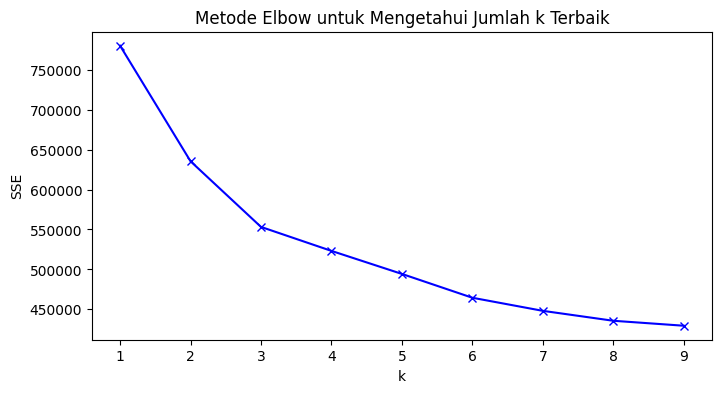

In [ ]:
# Mencari K terbaik
# List nilai SSE
sse = []

# Cari k terbaik dari 1-10
K = range(1,10)

# Cek nilai SSE setiap k
for k in K:
 kmeanModel = KMeans(n_clusters=k, random_state=42)
 kmeanModel.fit(X_scaled)
 sse.append(kmeanModel.inertia_)

# Plotting the distortions
plt.figure(figsize=(8,4))
plt.plot(K, sse, "bx-")
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("Metode Elbow untuk Mengetahui Jumlah k Terbaik")
plt.show()

In [ ]:
# 4.	Clustering dengan Kmeans dan DBScan
# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
labels_kmeans = kmeans.predict(X_scaled)

# DBSCAN
db = DBSCAN(eps=3, min_samples=10).fit(X_scaled)
labels_dbscan = db.labels_

# Hitung jumlah cluster dan noise
n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_ = list(labels_dbscan).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Evaluasi
print("KMeans Silhouette:", silhouette_score(X_scaled, labels_kmeans))
print("KMeans Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_kmeans))
print("DBSCAN Silhouette:", silhouette_score(X_scaled, labels_dbscan))
print("DBSCAN Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_dbscan))


Estimated number of clusters: 3
Estimated number of noise points: 1509
KMeans Silhouette: 0.1857356607838196
KMeans Davies-Bouldin: 1.6558134556548947
DBSCAN Silhouette: 0.48075436095003854
DBSCAN Davies-Bouldin: 1.621295616442536


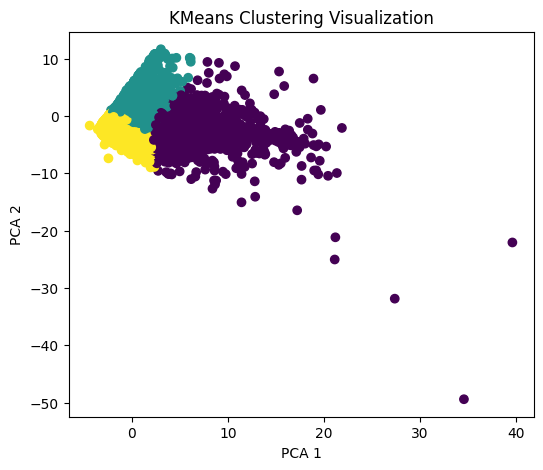

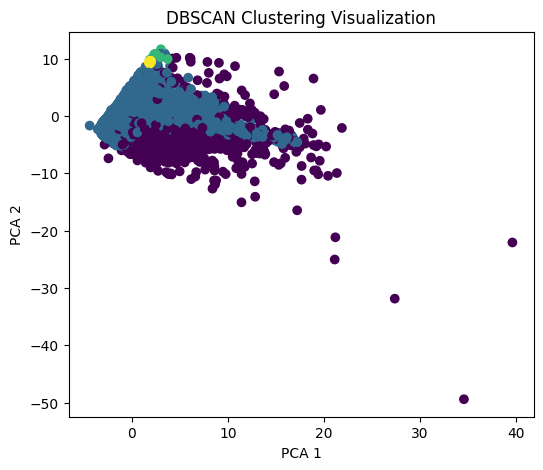

In [ ]:
#  5.	Visualisasi Clustering (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='viridis')
plt.title("KMeans Clustering Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='viridis')
plt.title("DBSCAN Clustering Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [ ]:
# 6.	ANN
import random

dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Build index
for i, vec in enumerate(X_scaled):
    ann.add_item(i, vec)
ann.build(50)

# Pilih 3–5 query point secara acak
import random
query_points = random.sample(range(X_scaled.shape[0]), 5)

for query_idx in query_points:
  query = X_scaled[query_idx]
  neighbors, distances = ann.get_nns_by_vector(query, n=5, include_distances=True)

  print(f"Query Point Index: {query_idx}")
  print("Nearest Neighbors and Distances:")
  for n, d in zip(neighbors, distances):
    print(f"Neighbor Index: {n} | Distance: {d:.4f} | Cluster (KMeans): {labels_kmeans[n]}")


Query Point Index: 22561
Nearest Neighbors and Distances:
Neighbor Index: 22561 | Distance: 0.0000 | Cluster (KMeans): 2
Neighbor Index: 12742 | Distance: 0.4157 | Cluster (KMeans): 2
Neighbor Index: 4927 | Distance: 0.7139 | Cluster (KMeans): 2
Neighbor Index: 28095 | Distance: 0.7974 | Cluster (KMeans): 2
Neighbor Index: 4605 | Distance: 0.8230 | Cluster (KMeans): 2
Query Point Index: 25399
Nearest Neighbors and Distances:
Neighbor Index: 25399 | Distance: 0.0000 | Cluster (KMeans): 2
Neighbor Index: 27750 | Distance: 0.1347 | Cluster (KMeans): 2
Neighbor Index: 3982 | Distance: 0.2828 | Cluster (KMeans): 2
Neighbor Index: 21643 | Distance: 0.3083 | Cluster (KMeans): 2
Neighbor Index: 23431 | Distance: 0.3345 | Cluster (KMeans): 2
Query Point Index: 29144
Nearest Neighbors and Distances:
Neighbor Index: 29144 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 14054 | Distance: 0.1288 | Cluster (KMeans): 1
Neighbor Index: 10104 | Distance: 0.2314 | Cluster (KMeans): 1
Neighbor I

## Kesimpulan Singkat

1. Perbedaan hasil KMeans dan DBSCAN, mana yang lebih baik diantara kedua model ini dan jelaskan jawaban anda
    * Berdasarkan hasil clustering, DBSCAN memberikan hasil yang lebih baik daripada KMEANS. Dengan nilai Silhouette Score yang lebih tinggi (0.4807) dan Davies-Bouldin Index yang lebih rendah (1.6213).
2. Nilai metrik terbaik (Silhouette, DBI).
    * Metode yang terbaik yaitu DBSCAN, dengan Silhouette Score  (0.4807) dan Davies-Bouldin Index(1.6213), karena bisa menghasilkan cluster yang bisa mendeteksi 1.509 data noise.
3. Hasil query Annoy: apakah tetangga yang ditemukan termasuk dalam cluster yang sama? Jelaskan jawaban anda.
    * Berdasarkan hasil ANN, semua tetangga terdekat dari setiap query point berada dalam cluster yang sama. Hal ini menunjukkan bahwa hasil clustering KMeans konsisten terhadap jarak antar data dan memiliki struktur pengelompokan yang stabil.
